In [307]:
import gensim
from gensim.models import Word2Vec
import pandas as pd
import warnings
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

# Create WordNetLemmatizer object
wnl = WordNetLemmatizer()


In [308]:
before_df = pd.read_csv("Before_Tokenized.csv")
after_df = pd.read_csv("After_Tokenized.csv")

before_df = before_df[["Subject_ID", "Tweet_ID", "Sentence"]]
after_df = after_df[["Subject_ID", "Tweet_ID", "Sentence"]]

# Function to remove the [CLS] and [SEP]
def trim_sentence(sentence):
    if len(sentence) > 10:  
        return sentence[5:-5]
    else:
        return "" 

# Apply the function to the Sentence column
before_df['Trimmed Sentence'] = before_df['Sentence'].apply(trim_sentence)
after_df['Trimmed Sentence'] = after_df['Sentence'].apply(trim_sentence)

# Concatenate all trimmed sentences into a single string 
before_corpus = before_df['Trimmed Sentence'].str.cat(sep='. ') 
after_corpus = after_df['Trimmed Sentence'].str.cat(sep='. ') 

before_words = word_tokenize(before_corpus)
after_words = word_tokenize(after_corpus)

# Lemmatize all words in a corpus
lemmatized_before = [[wnl.lemmatize(words) for words in before_words]]
lemmatized_after = [[wnl.lemmatize(words) for words in after_words]]

print(lemmatized_before[0][:20])


# df.to_csv("word2vectesting.csv", index=False)


['holy', 'fucking', 'shit', 'criticizing', 'Israel', 'antisemitic', '.', 'IS', 'antisemitic', 'putting', 'holocaustdenying', 'lunatic', 'think', 'Jews', 'control', 'weather', 'Homeland', 'Security', 'Committee', '.']


In [309]:
# Create CBOW model
before_model = gensim.models.Word2Vec(lemmatized_before, min_count=1, vector_size=100, window=5)
after_model = gensim.models.Word2Vec(lemmatized_after, min_count=1, vector_size=100, window=5)

# Create Skip Gram model
model2 = gensim.models.Word2Vec(before_corpus, min_count=1, vector_size=100, window=5, sg=1)

In [310]:
# Function to get word vector or a zero vector for unseen words
def get_word_vector(word, model):
    if word in model.wv.vocab:
        return model.wv[word]
    else:
        return [0] * model.vector_size  # Return a zero vector of the same size

def analogy(model, x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

# Example usage
word = "Israel"
# vector = get_word_vector(word, before_model)
# print(vector)

print(before_model.wv.most_similar('Palestinian')) # Finding frequently used together words
# print(before_model.wv['Israel']) # Getting embeddings


[('NATOs', 0.2489338219165802), ('policy', 0.2394576221704483), ('monster', 0.23875576257705688), ('wrong', 0.2324734926223755), ('Qatar', 0.2295173555612564), ('individual', 0.22359398007392883), ('Palestine', 0.21717189252376556), ('radical', 0.21694208681583405), ('routinely', 0.21573381125926971), ('My', 0.21321091055870056)]


In [311]:
# Print results
# print("Cosine similarity between 'alice' " + "and 'wonderland' - CBOW : ", before_model.wv.similarity('Israel', 'rude'))

Visualizing word embeddings

In [312]:
def display_pca_scatterplot(model, words=None, title= "", sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.key_to_index.keys()), sample)
        else:
            words = list(model.wv.key_to_index.keys())
        
    word_vectors = np.array([model.wv[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    plt.title(title)
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.0009, y+0.0009, word)
    plt.show()
    

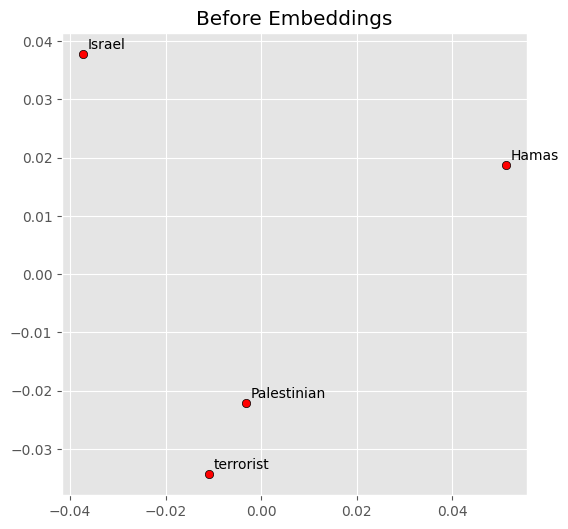

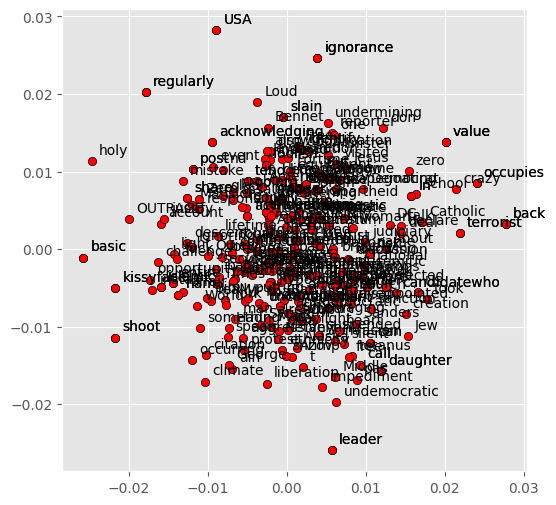

In [313]:
display_pca_scatterplot(before_model, 
                        ['Israel', 'Palestinian', 'Hamas', 'terrorist'],
                        "Before Embeddings")

display_pca_scatterplot(before_model, sample=300)


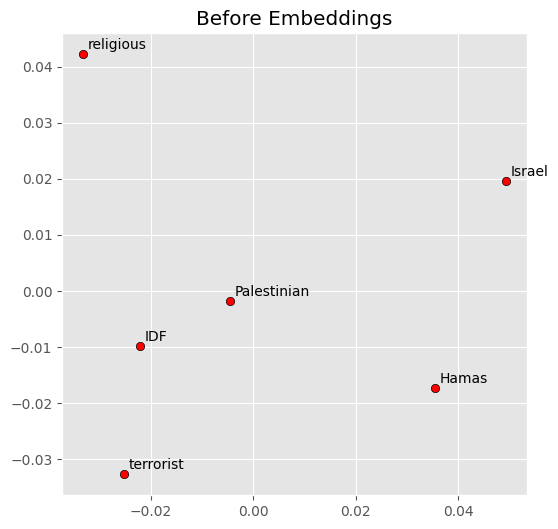

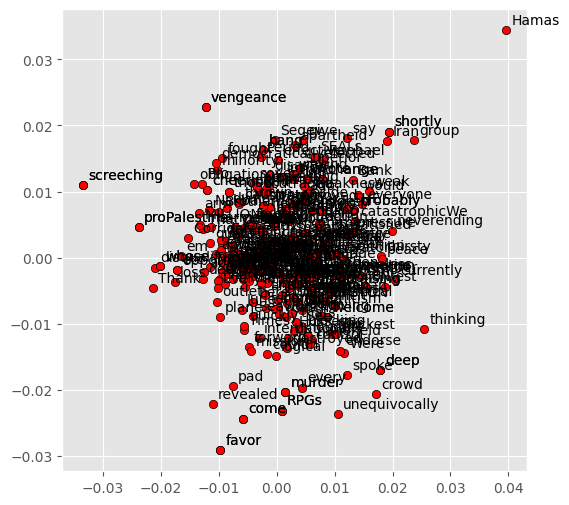

In [ ]:
display_pca_scatterplot(after_model, 
                        ['Israel', 'Palestinian', 'IDF', 'Hamas', 'terrorist', 'religious'],
                        "After Embeddings")

display_pca_scatterplot(after_model, sample=300)